# $m_\pi$ analysis

Program for measuring the pion mass. It computes the effective mass and fits the plateau. The correlation function is assumed to be precomputed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit

In [2]:
def Datos(path):
    data = [[],[],[]]
    with open(path) as fobj:
        for i, line in enumerate(fobj):
           # data.append([])
            if line.rsplit() != []:
                row = line.rsplit()   
                for j in range(len(row)):
                    data[j].append(float(row[j]))     
    return np.array(data)

def EffectiveMass(Corr,Nt):
    #We need the root of this function
    def f(x,Corr,t):
        #return Corr[t]/Corr[(t+1)%Nt] - np.cosh(x * (t-Nt/2))/ np.cosh(x * ( (t+1)%Nt - Nt/2 ))
        return Corr[t]/Corr[(t+1)%Nt] - np.cosh(x * (t-Nt/2))/ np.cosh(x * ( (t+1) - Nt/2 ))
    meff = []
    for t in range(Nt):
        sol = optimize.root_scalar(f, args=(Corr,t), method='secant', x0=0.5, x1=1, xtol=1e-15, rtol=1e-15, maxiter=1000)
        if sol.converged == True:
            meff.append(sol.root)
        else:
            print("Solution not found for t={0}".format(t))
            meff.append(np.nan)
    return np.array(meff)

def func(x, a, b):
    return a*np.exp((Nt/2-x)*b)

def kappa2mass(kappa):
    return 1/(2*kappa)-2

def mass2kappa(m0):
    return 1/(2*(m0+2))

def format_number(number):
    # Format the number with 2 decimal places
    s = f"{number:.2f}"
    # Remove the decimal point
    s = s.replace('.', '')
    if number == kappa2mass(0.247):
        s = '0024'
    return s

In [6]:
kappa2mass(0.248)

0.016129032258064502

In [7]:
format_number(kappa2mass(0.248))

'002'

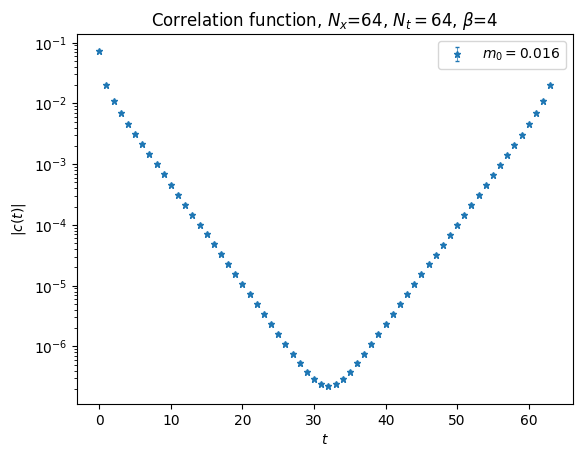

In [8]:
beta, Nx, Nt = 4, 64, 64
#masses = [kappa2mass(0.259),kappa2mass(0.255),kappa2mass(0.252),kappa2mass(0.251),kappa2mass(0.248),kappa2mass(0.247)]
masses = [kappa2mass(0.248)]

plt.title(r'Correlation function, $N_x$={0}, $N_t={1}$, $\beta$={2}'.format(Nx,Nt,beta))
plt.ylabel(r'$|c(t)|$')
plt.xlabel(r"$t$")

for m0 in masses:
    #path = 'confs/b{0}_{1}x{2}/2D_U1_Ns{1}_Nt{2}_b{0}_m{3}_corr.txt'.format(beta,Nx,Nt,format_number(m0))
    path = 'build/b{0}_{1}x{2}/2D_U1_Ns{1}_Nt{2}_b{0}_m{3}_corr.txt'.format(beta,Nx,Nt,format_number(m0))
    t, Corr, dCorr = Datos(path)
    Corr = abs(Corr)
    plt.errorbar(t,Corr,yerr=dCorr,\
        fmt='*',markersize='5',elinewidth=0.5,solid_capstyle='projecting',label='$m_0=${0}'.format(np.round(m0,3)), capsize=1.5)
plt.yscale('log')
plt.legend()
plt.show()

In [9]:
for t in range(Nt):
    print('C({0})= {1} +- {2}'.format(t,Corr[t],dCorr[t]))

C(0)= 0.07305925 +- 0.0001845254
C(1)= 0.02030584 +- 9.742812e-05
C(2)= 0.01109735 +- 8.135905e-05
C(3)= 0.006936038 +- 6.022113e-05
C(4)= 0.004577192 +- 4.115173e-05
C(5)= 0.003097075 +- 3.002177e-05
C(6)= 0.002119688 +- 2.251526e-05
C(7)= 0.001448647 +- 1.646397e-05
C(8)= 0.0009962076 +- 1.193909e-05
C(9)= 0.000679271 +- 8.996906e-06
C(10)= 0.0004608494 +- 6.613075e-06
C(11)= 0.0003141328 +- 4.668782e-06
C(12)= 0.0002142372 +- 3.42933e-06
C(13)= 0.0001471406 +- 2.638024e-06
C(14)= 0.0001014124 +- 2.067102e-06
C(15)= 6.996446e-05 +- 1.616271e-06
C(16)= 4.826569e-05 +- 1.23915e-06
C(17)= 3.327865e-05 +- 9.393664e-07
C(18)= 2.287718e-05 +- 6.873535e-07
C(19)= 1.559081e-05 +- 4.730249e-07
C(20)= 1.062767e-05 +- 3.235321e-07
C(21)= 7.231936e-06 +- 2.163731e-07
C(22)= 4.922392e-06 +- 1.458816e-07
C(23)= 3.369823e-06 +- 1.008914e-07
C(24)= 2.326423e-06 +- 7.459413e-08
C(25)= 1.601226e-06 +- 5.569733e-08
C(26)= 1.093347e-06 +- 4.122241e-08
C(27)= 7.511982e-07 +- 3.052652e-08
C(28)= 5.265212e

m0 = 0.016, kappa = 0.248,  mpi = 0.378 +- 0.006


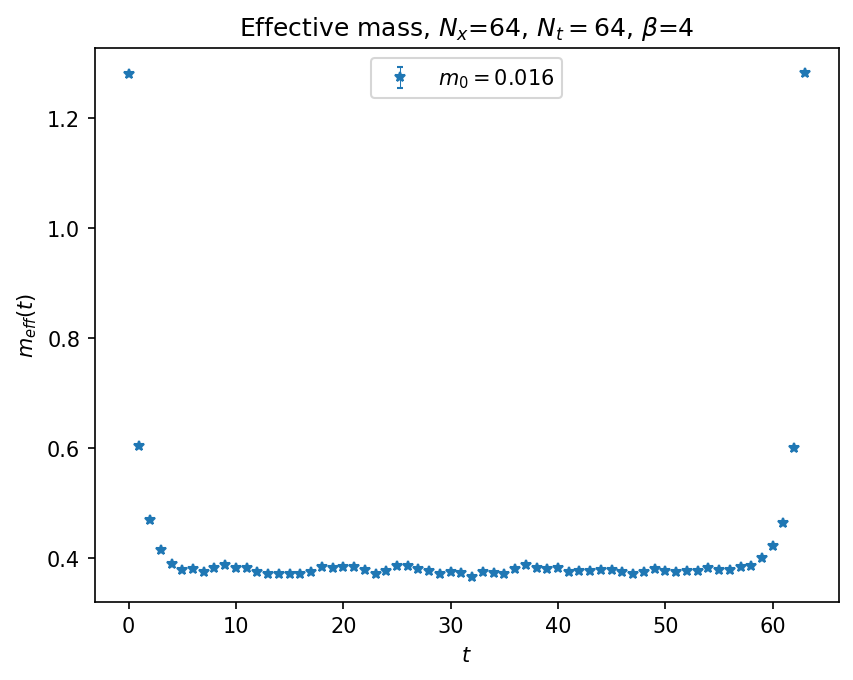

In [10]:
fig = plt.figure(dpi=150)
plt.title(r'Effective mass, $N_x$={0}, $N_t={1}$, $\beta$={2}'.format(Nx,Nt,beta))
plt.ylabel(r'$m_{eff}(t)$')
plt.xlabel(r"$t$")

for m0 in masses:
    #path = 'confs/b{0}_{1}x{2}/2D_U1_Ns{1}_Nt{2}_b{0}_m{3}_corr.txt'.format(beta,Nx,Nt,format_number(m0))
    path = 'build/b{0}_{1}x{2}/2D_U1_Ns{1}_Nt{2}_b{0}_m{3}_corr.txt'.format(beta,Nx,Nt,format_number(m0))
    t, Corr, dCorr = Datos(path)
    Corr = abs(Corr)
    meff = EffectiveMass(Corr,Nt)
    plt.errorbar(t,meff,yerr=meff*0,\
        fmt='*',markersize='5',elinewidth=0.5,solid_capstyle='projecting',label='$m_0=${0}'.format(np.round(m0,3)), capsize=1.5)
    print("m0 = {0}, kappa = {1},  mpi = {2} +- {3}".format(np.round(m0,3),mass2kappa(m0), 
                                                                     np.round(np.mean(meff[11:30]),3),
                                                                    np.round(np.std(meff[11:30]),3)))
#plt.yscale('log')
plt.legend() 
plt.show()
#fig.savefig("meff.pdf")

In [11]:
print("mpi={0} +- {1}".format(np.round(0.3773428923847352,3),np.round(0.0068873628520349705,3))) 

mpi=0.377 +- 0.007


In [ ]:
#popt, pcov = curve_fit(func, np.arange(Nt)[4:8], Corr[4:8],p0=[0.1,0.1])
#print(popt)
#plt.plot(np.arange(Nt), func(np.arange(Nt), *popt), 'r-',
#         label='fit: a=%5.3f, b=%5.3f'% tuple(popt))
#plt.scatter(np.arange(Nt),Corr)
#plt.yscale('log')

## Fortran vs C++ results

Comparing my simulation results with the Fortran code which I used long time ago an which is tested

In [ ]:
m0 = np.array([kappa2mass(0.25),kappa2mass(0.255),kappa2mass(0.26),kappa2mass(0.265)])
mpi_C = np.array([0.5902800006825173,0.532153301674059, 0.439023713759679, 0.3518992029346969  ])
dmpi_C = np.array([0.03879288389493793,0.04257417738305564, 0.01704753613144535, 0.00926040989633477 ]) #I don't use Jackknife here, only a naive error implementation 

mpi_F = np.array([0.59132032615137209,  0.52376242060378120,  0.45498548094226249, 0.37063943725059129])         
dmpi_F = np.array([3.0800773884529045E-003, 2.7502998222633974E-003, 1.9926772819619885E-002, 1.6938266250340936E-002 ]) 

fig = plt.figure(dpi=150)
plt.title(r'$m_\pi$, $N_x$={0}, $N_t={1}$, $\beta$={2}'.format(Nx,Nt,beta))
plt.ylabel(r'$m_{\pi}$')
plt.xlabel(r"$m_0$")
plt.errorbar(m0,mpi_C,yerr=dmpi_C,\
        fmt='*',markersize='5',elinewidth=0.5,solid_capstyle='projecting',label='C++', capsize=1.5)
plt.errorbar(m0,mpi_F,yerr=dmpi_F,\
        fmt='*',markersize='5',elinewidth=0.5,solid_capstyle='projecting',label='Fortran', capsize=1.5)
plt.legend()
plt.show()
#fig.savefig("Mpi.pdf")



SG_C = np.array([0.56054193699302834,0.55232957284976547,0.54831505751146892,0.538985 ])      
dSG_C = np.array([0.0013579647475999619, 0.0016871376291731546,0.0017741588444640263,0.00154538])
SG_F = np.array([0.55819E+00,0.55786E+00,0.54574E+00, 0.53850E+00   ]) 
dSG_F =  np.array([0.157E-02,0.125E-02,0.168E-02,0.141E-02  ])  

fig = plt.figure(dpi=150)
plt.title(r'Average gauge action/V, $N_x$={0}, $N_t={1}$, $\beta$={2}'.format(Nx,Nt,beta))
plt.ylabel(r'$S_G/(N_x N_t)$')
plt.xlabel(r"$m_0$")
plt.errorbar(m0,SG_C,yerr=dSG_C,\
        fmt='*',markersize='5',elinewidth=0.5,solid_capstyle='projecting',label='C++', capsize=1.5)
plt.errorbar(m0,SG_F,yerr=dSG_F,\
        fmt='*',markersize='5',elinewidth=0.5,solid_capstyle='projecting',label='Fortran', capsize=1.5)
plt.legend()
plt.show()
#fig.savefig("SG.pdf")